# Mobile & Wearable Computing
## Assignment 04 - Clarissa Kümhof

### Analysis of Physiological Data

# Hands on!

In [1]:
###############
# Some methods and functions to support our analysis
# NOTE: this code is not shown in the slides, but you should run it!
# Feel free to give a look on how we load the data, extract features and all others
# methods we did not describe explicitly in the lecture
###############

# imports
import numpy as np
import pandas as pd
from typing import Literal, Union
from IPython.display import display
import matplotlib.pyplot as plt

from scipy.signal import butter, lfilter, filtfilt
from pandas import Series, DataFrame
from numpy import ndarray

from plotly import __version__
from plotly.offline import (
    download_plotlyjs,
    init_notebook_mode,
    plot,
    iplot,
)

init_notebook_mode(connected=True)
import plotly.offline as offline
import plotly.graph_objs as go

from neurokit2.eda import eda_peaks
from warnings import warn

from time import time
from sys import getsizeof

from json import load as load_json
from typing import Any

from logging import getLogger
from typing import Any
from numpy import ndarray, mean, std, gradient, isnan, array
from scipy.stats import linregress
from neurokit2.eda import eda_peaks


# Set notebook mode to work in offline
offline.init_notebook_mode(connected=True)


def butter_lowpass_filter_filtfilt(
    data: Series, cutoff: float, fs: int, order: int
) -> ndarray:
    """Method to create and then apply a digital filter forward and backward to a signal.

    Args:
        data (ndarray): timeseries to be filtered, e.g. EDA data signal
        cutoff (float): cutoff point for the lowpass, e.g. `5`
        fs (int): frequency of the singal, e.g. `64`
        order (int): order for the filter, e.g. `2`

    Returns:
        ndarray: returns the data filtered
    """
    b, a = butter_lowpass(cutoff, fs, order=order)
    if isinstance(data, DataFrame):
        y: ndarray = filtfilt(b=b, a=a, x=data.iloc[:, 0].values)
        y = stack([y, data.iloc[:, 1].values], axis=1)
    elif isinstance(data, Series):
        y: ndarray = filtfilt(b=b, a=a, x=data.values)
    else:
        raise TypeError(
            f"The method takes as input either pandas Dataframe or Series objects. Recevied {type(data)} instead"
        )
    return y


def butter_lowpass(
    cutoff: float, fs: int, order: int
) -> tuple[float, float]:
    """Figure out the numerator (`b`) and denominator (`a`) coefficients for a linear digital
    filter

    Args:
        cutoff (float): cutoff value
        fs (int): frequency of the signal
        order (int): order for the Butterworth filter

    Returns:
        (tuple): numerator and denominator coefficients for the lowpass filter
    """
    # NOTE: Nyquist frequeny is half the sampling frequency
    nyq = 0.5 * fs
    # NOTE: Normalization of the cutoff signal
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    return b, a


def make_interactive_lineplot(
    data: pd.DataFrame,
    x: Union[str, Literal["index"], list[Union[str, Literal["index"]]]],
    y: Union[str, Literal["index"], list[Union[str, Literal["index"]]]],
    name: Union[str, list[str]],
    title: str,
    xlabel: str = "",
    ylabel: str = "",
    **kwargs,
):
    traces = list()
    if (
        isinstance(x, list)
        and isinstance(y, list)
        and isinstance(name, list)
    ):
        for x_val, y_val, name_val in zip(x, y, name):
            trace = go.Scatter(
                x=data[x_val] if x_val != "index" else data.index,
                y=data[y_val] if y_val != "index" else data.index,
                name=name_val,
            )
            traces.append(trace)
    elif (
        isinstance(x, str)
        and isinstance(y, str)
        and isinstance(name, str)
    ):
        trace = go.Scatter(
            x=data[x] if x != "index" else data.index,
            y=data[y] if y != "index" else data.index,
            name=name,
        )
        traces.append(trace)
    else:
        raise TypeError(
            f"x, y and name must be either all lists or all strings. Got x: {type(x)}, y: {type(y)}, name: {type(name)}"
        )

    default_rangeselector = dict(
        buttons=list(
            [
                dict(
                    count=1,
                    label="1m",
                    step="month",
                    stepmode="backward",
                ),
                dict(
                    count=6,
                    label="6m",
                    step="month",
                    stepmode="backward",
                ),
                dict(step="all"),
            ]
        )
    )

    layout = dict(
        title=title,
        xaxis=dict(
            rangeselector=kwargs.get(
                "rangeselector", default_rangeselector
            ),
            rangeslider=dict(),
            type=kwargs.get("xtype", "date"),
            title=xlabel,
        ),
        yaxis=dict(
            title=ylabel,
        ),
    )
    fig = dict(data=traces, layout=layout)
    indexes = []

    offline.iplot(fig, filename=kwargs.get("filename", None))


def normalize_signals(x: np.ndarray) -> np.ndarray:
    """
    This method takes as input an array and perform the normalization (min-max) over it.

    Args:
        x (ndarray): input array

    Returns:
        (ndarray): array normalized

    """
    max_val: float = np.max(x)
    min_val: float = np.min(x)
    return (x - min_val) / (max_val - min_val)


def calculate_rise_time(
    signal: np.ndarray, sampling_rate: int
) -> float:
    """
    Calculates the rise time of an EDA physiological signal.

    Parameters:
        signal (np.ndarray): EDA physiological signal.
        sampling_rate (int): Sampling rate of the signal in Hz.

    Returns:
        float: Rise time in seconds.
    """
    peak_amplitude = np.max(signal)
    threshold_10 = 0.1 * peak_amplitude
    threshold_90 = 0.9 * peak_amplitude

    # Find the indices where the signal crosses the 10% and 90% thresholds
    index_10 = np.argmax(signal >= threshold_10)
    index_90 = np.argmax(signal >= threshold_90)

    # Calculate the rise time in seconds
    rise_time = (index_90 - index_10) / sampling_rate

    return rise_time


def calculate_decay_time(
    signal: np.ndarray, sampling_rate: int
) -> float:
    """
    Calculates the decay time of an EDA physiological signal.

    Parameters:
        signal (np.ndarray): EDA physiological signal.
        sampling_rate (int): Sampling rate of the signal in Hz.

    Returns:
        float: Decay time in seconds.
    """
    peak_amplitude = np.max(signal)
    threshold_10 = 0.1 * peak_amplitude
    threshold_90 = 0.9 * peak_amplitude

    # Find the indices where the signal crosses the 10% and 90% thresholds
    index_10 = np.argmax(signal >= threshold_10)
    index_90 = np.argmax(signal >= threshold_90)

    # Calculate the decay time in seconds
    decay_time = (index_10 - index_90) / sampling_rate

    return decay_time


def extract_features(
    data: np.ndarray, sampling_rate: int
) -> pd.Series:
    """
    This method extracts hand-crafted features for EDA signals.

    Args:
        data (ndarray): input array of EDA data
        sampling_rate (int): sampling rate of the EDA signal

    Returns:
        (Series): dataframe with the features extracted as indexes

    """
    if not isinstance(data, np.ndarray):
        raise TypeError(
            f"Input data must be a numpy array. Got {type(data)} instead"
        )
    min_feat: float = np.min(data)
    max_feat: float = np.max(data)
    mean_feat: float = np.mean(data)
    std_feat: float = np.std(data)
    rise_time = calculate_rise_time(data, sampling_rate=sampling_rate)
    decay_time = calculate_decay_time(
        data, sampling_rate=sampling_rate
    )
    dynamic_range_feat: float = max_feat - min_feat
    # NOTE: we have to cast to float otherwise the linear regression might fail
    # with the attribute error "float object has no attribute 'shape'".
    # See https://stackoverflow.com/questions/53200129/attributeerror-float-object-has-no-attribute-shape-when-using-linregress
    slope_feat, _, _, _, _ = linregress(
        np.asarray(range(len(data)), dtype=float).astype(float),
        data.astype(float),
    )
    absolute_slope_feat: float = abs(slope_feat)
    first_derivative_data: ndarray = gradient(data)
    first_derivetive_mean_feat: float = mean(first_derivative_data)
    first_derivative_std_feat: float = std(first_derivative_data)

    try:
        eda_peaks_result: dict[str, Any] = eda_peaks(
            data,
            sampling_rate=sampling_rate,
        )
    except ValueError as e:
        # NOTE: sometimes, when no peaks are detected, as ValueError is thrown by the
        # neurokit2 method. We solve this in a very simplistic way
        warn(f"Could not extract EDA peaks. Reason: {e}")
        eda_peaks_result: tuple[None, dict[str, Any]] = (
            None,
            dict(SCR_Peaks=[], SCR_Amplitude=[0]),
        )
    number_of_peaks_feat: int = len(eda_peaks_result[1]["SCR_Peaks"])
    return pd.Series(
        [
            min_feat,
            max_feat,
            mean_feat,
            std_feat,
            number_of_peaks_feat,
            rise_time,
            decay_time,
            dynamic_range_feat,
            slope_feat,
            absolute_slope_feat,
            first_derivetive_mean_feat,
            first_derivative_std_feat,
        ],
        index=[
            "Min",
            "Max",
            "Mean",
            "Std",
            "Num Peaks",
            "Rise Time",
            "Decay Time",
            "Dynamic Range",
            "Slope",
            "Absolute Slope",
            "First Derivative Mean",
            "First Derivative Std",
        ],
    )

In [2]:
start = time()
eda_data: pd.DataFrame = pd.read_csv(
    "./assignment_data.csv", index_col=0
)
print("Loading time %.2fs" % (time() - start))
print(f"EDA data size: %.2fMB" % (getsizeof(eda_data) / 1e6))
# convert the timestamp column to the correct class
eda_data["timestamp"] = pd.to_datetime(eda_data["timestamp"], infer_datetime_format=True)


Loading time 5.63s
EDA data size: 156.98MB


In [3]:
display(eda_data.head())

,username,session,timestamp,EDA,phasic-EDA,tonic-EDA,engagement
56153,U11,27Feb,2017-02-27 08:32:00.250000+01:00,0.553862,0.599247,1.916187,1.0
56154,U11,27Feb,2017-02-27 08:32:00.500000+01:00,0.552070,0.563805,1.938148,1.0
56155,U11,27Feb,2017-02-27 08:32:00.750000+01:00,0.550447,0.535159,1.954521,1.0
56156,U11,27Feb,2017-02-27 08:32:01+01:00,0.549133,0.514297,1.965503,1.0
56157,U11,27Feb,2017-02-27 08:32:01.250000+01:00,0.548717,0.505345,1.971287,1.0


# Preprocessing

### 1. Filtering

In [4]:
import numpy as np

eda_data["filt-EDA"] = (
    eda_data.groupby(["username", "session"], group_keys=False)
    .apply(
        lambda x: butter_lowpass_filter_filtfilt(
            data=x["EDA"], fs=4, cutoff=0.4, order=1
        )
    )
    .explode()
    .values
)

In [5]:
display(eda_data.head())

,username,session,timestamp,EDA,phasic-EDA,tonic-EDA,engagement,filt-EDA
56153,U11,27Feb,2017-02-27 08:32:00.250000+01:00,0.553862,0.599247,1.916187,1.0,0.553976
56154,U11,27Feb,2017-02-27 08:32:00.500000+01:00,0.552070,0.563805,1.938148,1.0,0.552745
56155,U11,27Feb,2017-02-27 08:32:00.750000+01:00,0.550447,0.535159,1.954521,1.0,0.551813
56156,U11,27Feb,2017-02-27 08:32:01+01:00,0.549133,0.514297,1.965503,1.0,0.551489
56157,U11,27Feb,2017-02-27 08:32:01.250000+01:00,0.548717,0.505345,1.971287,1.0,0.552171


### 2. Normalization

In [6]:
eda_data["norm-EDA"] = (
    eda_data.groupby(["username", "session"])
    .apply(lambda x: normalize_signals(x["filt-EDA"]))
    .explode()
    .values
)

In [7]:
display(eda_data.head())

,username,session,timestamp,EDA,phasic-EDA,tonic-EDA,engagement,filt-EDA,norm-EDA
56153,U11,27Feb,2017-02-27 08:32:00.250000+01:00,0.553862,0.599247,1.916187,1.0,0.553976,0.368789
56154,U11,27Feb,2017-02-27 08:32:00.500000+01:00,0.552070,0.563805,1.938148,1.0,0.552745,0.367958
56155,U11,27Feb,2017-02-27 08:32:00.750000+01:00,0.550447,0.535159,1.954521,1.0,0.551813,0.367328
56156,U11,27Feb,2017-02-27 08:32:01+01:00,0.549133,0.514297,1.965503,1.0,0.551489,0.36711
56157,U11,27Feb,2017-02-27 08:32:01.250000+01:00,0.548717,0.505345,1.971287,1.0,0.552171,0.36757


### 3. Segmentation & Feature Extraction

In [8]:
window_size_in_sec: int = 10
spl_rate: int = 4
window_size_in_sampling_rate: int = window_size_in_sec * spl_rate

In [9]:
def create_segments(
    x: pd.DataFrame, window_size_in_sampling_rate: int
) -> list[pd.DataFrame]:
    starts: pd.Series = x[::window_size_in_sampling_rate]["timestamp"]
    ends: pd.Series = (
        starts
        + pd.Timedelta(f"{window_size_in_sec}s")
        - pd.Timedelta(f"{1/spl_rate}s")
    )

    x = x.set_index("timestamp")
    segments: list[pd.DataFrame] = [
        x.loc[start:end] for start, end in zip(starts, ends)
    ]
    return segments

In [10]:
def segment_and_extract(
    x: pd.DataFrame, window_size_in_sampling_rate: int
) -> pd.DataFrame:
    segments = create_segments(x, window_size_in_sampling_rate)

    extracted_features: list[tuple[pd.Series, int]] = [
        (
            extract_features(
                data=segment["norm-EDA"].values.astype(float),
                sampling_rate=spl_rate,
            ),
            segment["engagement"].mean(),
        )
        for segment in segments
        if segment["engagement"].mean() == 0
        or segment["engagement"].mean() == 1
    ]

    engagement_values = [eng for _, eng in extracted_features]
    extracted_features = [feat for feat, _ in extracted_features]
    extracted_features = pd.concat(extracted_features, axis=1).T
    extracted_features["engagement"] = engagement_values
    return extracted_features

In [11]:
# NOTE: this can take around 10/20 seconds to run
eda_features = eda_data.groupby(["username", "session"]).apply(
    lambda x: segment_and_extract(x, window_size_in_sampling_rate)
)

/opt/anaconda3/lib/python3.9/site-packages/neurokit2/eda/eda_peaks.py:127: RuntimeWarning:

All-NaN slice encountered

/var/folders/8b/1r42p3g57tb_w83ks_5pkrtw0000gn/T/ipykernel_39944/674889496.py:296: UserWarning:

Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity

/var/folders/8b/1r42p3g57tb_w83ks_5pkrtw0000gn/T/ipykernel_39944/674889496.py:296: UserWarning:

Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity

/opt/anaconda3/lib/python3.9/site-packages/neurokit2/eda/eda_peaks.py:127: RuntimeWarning:

All-NaN slice encountered

/opt/anaconda3/lib/python3.9/site-packages/neurokit2/eda/eda_peaks.py:127: RuntimeWarning:

All-NaN slice encountered

/var/folders/8b/1r42p3g57tb_w83ks_5pkrtw0000gn/T/ipykernel_39944/674889496.py:296: UserWarning:

Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity

/var/folders/8b/1r42p3g57tb_w83

/opt/anaconda3/lib/python3.9/site-packages/neurokit2/eda/eda_peaks.py:127: RuntimeWarning:

All-NaN slice encountered

/var/folders/8b/1r42p3g57tb_w83ks_5pkrtw0000gn/T/ipykernel_39944/674889496.py:296: UserWarning:

Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity



In [12]:
eda_features.head()

Min       Max      Mean       Std  Num Peaks  \
username session                                                        
U11      27Feb   0  0.313616  0.415355  0.381506  0.027443        1.0   
                 1  0.264152  0.411775  0.309547  0.047527        1.0   
                 2  0.320324  0.404522  0.392145  0.017502        1.0   
                 3  0.276819  0.383269  0.343568  0.028917        1.0   
                 4  0.201607  0.284567  0.256255  0.029752        1.0   

                    Rise Time  Decay Time  Dynamic Range     Slope  \
username session                                                     
U11      27Feb   0       1.75       -1.75       0.101738 -0.000924   
                 1       1.00       -1.00       0.147624 -0.003155   
                 2       0.75       -0.75       0.084198  0.000406   
                 3       0.00        0.00       0.106450 -0.002449   
                 4       0.00        0.00       0.082961 -0.001944   

                    Absolute Slope  First Derivative Mean  \
username session                                            
U11      27Feb   0        0.000924              -0.001378   
                 1        0.003155              -0.000083   
                 2        0.000406               0.001810   
                 3        0.002449              -0.002748   
                 4        0.001944              -0.001265   

                    First Derivative Std  engagement  
username session                                      
U11      27Feb   0              0.004805         1.0  
                 1              0.009659         1.0  
                 2              0.005487         1.0  
                 3              0.002238         1.0  
                 4              0.004755         1.0

# Statistical Analysis

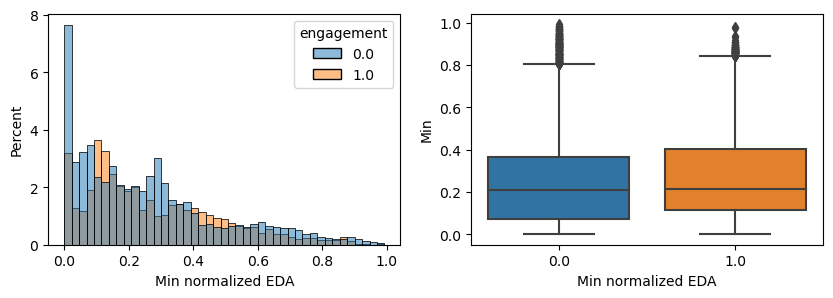

In [13]:
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
sns.histplot(
    ax=axs[0],
    data=eda_features,
    x="Min",
    hue="engagement",
    stat="percent",
)
#eda_features.plot.box(ax=axs[1], column="Min", by="engagement")
sns.boxplot(
    ax=axs[1],
    data=eda_features,
    x="engagement",
    y="Min",
)
for ax in axs:
    ax.set_xlabel("Min normalized EDA")
plt.show()

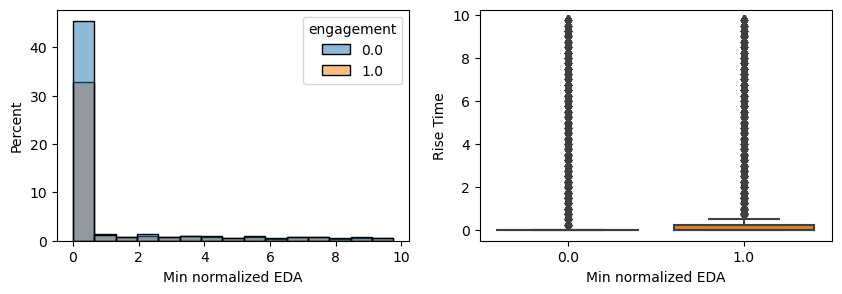

In [14]:
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
sns.histplot(
    ax=axs[0],
    data=eda_features,
    x="Rise Time",
    hue="engagement",
    stat="percent",
)
#eda_features.plot.box(ax=axs[1], column="Rise Time", by="engagement")
sns.boxplot(
    ax=axs[1],
    data=eda_features,
    x="engagement",
    y="Rise Time",
)
for ax in axs:
    ax.set_xlabel("Min normalized EDA")
plt.show()

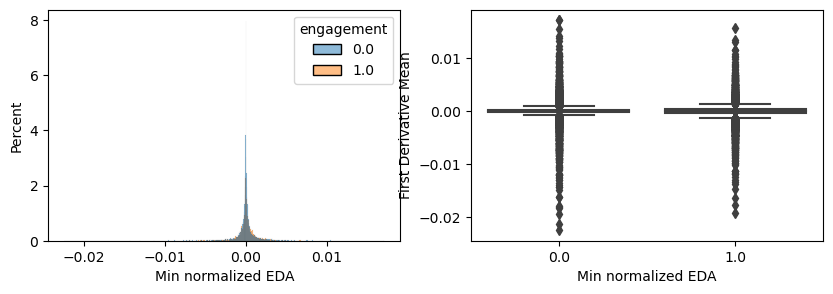

In [15]:
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
sns.histplot(
    ax=axs[0],
    data=eda_features,
    x="First Derivative Mean",
    hue="engagement",
    stat="percent",
)
#eda_features.plot.box(ax=axs[1], column="First Derivative Mean", by="engagement")
sns.boxplot(
    ax=axs[1],
    data=eda_features,
    x="engagement",
    y="First Derivative Mean",
)
for ax in axs:
    ax.set_xlabel("Min normalized EDA")
plt.show()

# Machine Learning

### 1. 5-fold cross validation

In [16]:
X = eda_features.drop("engagement", axis=1).values
y = eda_features["engagement"].values

<Axes: >

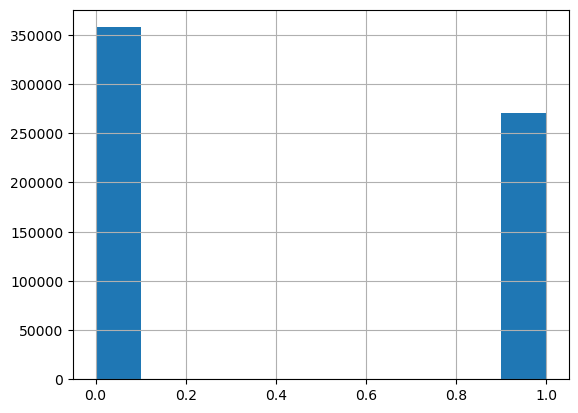

In [17]:
eda_data["engagement"].hist()

In [18]:
groups: np.ndarray = eda_features.index.get_level_values(0).values
print(len(np.unique(groups)))

13


In [19]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [20]:
# load xgboost and cross validation
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

# perform cross validation with xgboost and balanced accuracy
xgb = XGBClassifier(random_state=42)
model = DummyClassifier(strategy="uniform", random_state=42)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svm = svm.SVC(random_state=42)
#clf.fit(X, y)

rfc = RandomForestClassifier(n_estimators=10, random_state=42)
#RFC.fit(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
gnb = GaussianNB()

cv_5fold_results_xgboost = cross_validate(
    xgb,
    X.reshape(X.shape[0], -1),
    y,
    cv=kf,
    scoring="balanced_accuracy",
    return_train_score=True,
)
cv_5fold_results_dummy = cross_validate(
    model,
    X.reshape(X.shape[0], -1),
    y,
    cv=kf,
    scoring="balanced_accuracy",
    return_train_score=True,
)
cv_5fold_results_svm = cross_validate(
    svm,
    X.reshape(X.shape[0], -1),
    y,
    cv=kf,
    scoring="balanced_accuracy",
    return_train_score=True,
)

cv_5fold_results_rfc = cross_validate(
    rfc,
    X.reshape(X.shape[0], -1),
    y,
    cv=kf,
    scoring="balanced_accuracy",
    return_train_score=True,
)
cv_5fold_results_nbc = cross_validate(
    gnb,
    X.reshape(X.shape[0], -1),
    y,
    cv=kf,
    scoring="balanced_accuracy",
    return_train_score=True,
)

In [21]:
print(
    f"Average validation score of XGBoost: %.2f ± %.2f %%"
    % (
        100 * np.mean(cv_5fold_results_xgboost["test_score"]),
        100 * np.std(cv_5fold_results_xgboost["test_score"]),
    )
)
print(
    f"Average validation score of DummyClassifier: %.2f ± %.2f %%"
    % (
        100 * np.mean(cv_5fold_results_dummy["test_score"]),
        100 * np.std(cv_5fold_results_dummy["test_score"]),
    )
)
print(
    f"Average validation score of Support Vector Machine: %.2f ± %.2f %%"
    % (
        100 * np.mean(cv_5fold_results_svm["test_score"]),
        100 * np.std(cv_5fold_results_svm["test_score"]),
    )
)
print(
    f"Average validation score of Random Forest Classifier: %.2f ± %.2f %%"
    % (
        100 * np.mean(cv_5fold_results_rfc["test_score"]),
        100 * np.std(cv_5fold_results_rfc["test_score"]),
    )
)
print(
    f"Average validation score of Naive Bayes Classifier: %.2f ± %.2f %%"
    % (
        100 * np.mean(cv_5fold_results_nbc["test_score"]),
        100 * np.std(cv_5fold_results_nbc["test_score"]),
    )
)

Average validation score of XGBoost: 63.40 ± 0.67 %
Average validation score of DummyClassifier: 50.49 ± 0.24 %
Average validation score of Support Vector Machine: 50.05 ± 0.12 %
Average validation score of Random Forest Classifier: 61.10 ± 0.70 %
Average validation score of Naive Bayes Classifier: 54.81 ± 1.07 %


<!-- write in red -->
<span style="color:red">When performing the random shuffling of our data, we aid the model in learning – first by avoiding accidental "Leave One User Out", and second by avoiding temporal dependencies. Nonetheless, this approach is limited in estimating how the model might perform on unseen days or users. It also has an issue with "temporal leakage": we're using data from the last to predict the future in some instances. However, for this tutorial it is mostly fine, and it is indeed a validation paradigm implemented in the research field.</span>

### 2. Leave One Subject Out Cross Validation

<!-- write in red -->
<span style="color:red">Similarly to the other validation method, we want to shuffle the data in each fold. However, the meethod LeaveOneGroupOut does not allow for data shuffling. We're using the `shuffle` method from `scikit-learn` to perform the shuffling on the initial dataset (but we shuffle with the groups as well!).</span>.

In [22]:
from sklearn.utils import shuffle

X, y, groups = shuffle(X, y, groups, random_state=42)

In [25]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, LeaveOneGroupOut
from sklearn.dummy import DummyClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

# perform cross validation with xgboost and balanced accuracy
xgb = XGBClassifier(random_state=42)
baseline = DummyClassifier(strategy="uniform", random_state=42)
groups_instance = LeaveOneGroupOut()

svm = svm.SVC(random_state=42)
#clf.fit(X, y)

rfc = RandomForestClassifier(n_estimators=10, random_state=42)
#RFC.fit(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
gnb = GaussianNB()

cv_loso_results_xgboost = cross_validate(
    xgb,
    X,
    y,
    cv=groups_instance.split(X, y, groups=groups),
    scoring="balanced_accuracy",
    return_train_score=True,
)
cv_loso_results_dummy = cross_validate(
    baseline,
    X,
    y,
    cv=groups_instance.split(X, y, groups=groups),
    scoring="balanced_accuracy",
    return_train_score=True,
)
cv_loso_results_svm = cross_validate(
    svm,
    X,
    y,
    cv=groups_instance.split(X, y, groups=groups),
    scoring="balanced_accuracy",
    return_train_score=True,
)

cv_loso_results_rfc = cross_validate(
    rfc,
    X,
    y,
    cv=groups_instance.split(X, y, groups=groups),
    scoring="balanced_accuracy",
    return_train_score=True,
)
cv_loso_results_nbc = cross_validate(
    gnb,
    X,
    y,
    cv=groups_instance.split(X, y, groups=groups),
    scoring="balanced_accuracy",
    return_train_score=True,
)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2184: UserWarning:

y_pred contains classes not in y_true

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2184: UserWarning:

y_pred contains classes not in y_true

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2184: UserWarning:

y_pred contains classes not in y_true

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2184: UserWarning:

y_pred contains classes not in y_true

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2184: UserWarning:

y_pred contains classes not in y_true

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2184: UserWarning:

y_pred contains classes not in y_true

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2184: UserWarning:

y_pred contains classes not in y_true

/opt/anaconda3/lib/python3.9/site-package

In [26]:
print(
    f"Average validation score of XGBoost: %.2f ± %.2f %%"
    % (
        100 * np.mean(cv_loso_results_xgboost["test_score"]),
        100 * np.std(cv_loso_results_xgboost["test_score"]),
    )
)
print(
    f"Average validation score of DummyClassifier: %.2f ± %.2f %%"
    % (
        100 * np.mean(cv_loso_results_dummy["test_score"]),
        100 * np.std(cv_loso_results_dummy["test_score"]),
    )
)
print(
    f"Average validation score of Support Vector Machine: %.2f ± %.2f %%"
    % (
        100 * np.mean(cv_loso_results_svm["test_score"]),
        100 * np.std(cv_loso_results_svm["test_score"]),
    )
)
print(
    f"Average validation score of Random Forest Classifier: %.2f ± %.2f %%"
    % (
        100 * np.mean(cv_loso_results_rfc["test_score"]),
        100 * np.std(cv_loso_results_rfc["test_score"]),
    )
)
print(
    f"Average validation score of Naive Bayes Classifier: %.2f ± %.2f %%"
    % (
        100 * np.mean(cv_loso_results_nbc["test_score"]),
        100 * np.std(cv_loso_results_nbc["test_score"]),
    )
)

Average validation score of XGBoost: 41.92 ± 16.32 %
Average validation score of DummyClassifier: 49.83 ± 1.21 %
Average validation score of Support Vector Machine: 47.02 ± 36.52 %
Average validation score of Random Forest Classifier: 43.82 ± 17.67 %
Average validation score of Naive Bayes Classifier: 28.44 ± 22.48 %


### 3. Leave One Day (per user) Out Cross Validation

In [27]:
sessions: np.ndarray = eda_features.index.get_level_values(1).values
print(sessions)
print(np.unique(sessions))
print(len(np.unique(sessions)))

['27Feb' '27Feb' '27Feb' ... '7March' '7March' '7March']
['10March' '22Feb' '23Feb' '27Feb' '3March' '6March' '7March' '8March']
8


In [28]:
from sklearn.model_selection import GroupKFold

group_kfold = GroupKFold(n_splits=len(np.unique(sessions)))

cv_lodo_results_xgboost = cross_validate(
    xgb,
    X,
    y,
    cv=group_kfold.split(X, y, groups=sessions),
    scoring="balanced_accuracy",
    return_train_score=True,
)

cv_lodo_results_dummy = cross_validate(
    baseline,
    X,
    y,
    cv=group_kfold.split(X, y, groups=sessions),
    scoring="balanced_accuracy",
    return_train_score=True,
)

cv_lodo_results_svm = cross_validate(
    svm,
    X,
    y,
    cv=group_kfold.split(X, y, groups=sessions),
    scoring="balanced_accuracy",
    return_train_score=True,
)

cv_lodo_results_rfc = cross_validate(
    rfc,
    X,
    y,
    cv=group_kfold.split(X, y, groups=sessions),
    scoring="balanced_accuracy",
    return_train_score=True,
)
cv_lodo_results_nbc = cross_validate(
    gnb,
    X,
    y,
    cv=group_kfold.split(X, y, groups=sessions),
    scoring="balanced_accuracy",
    return_train_score=True,
)

print(
    f"Average validation score of XGBoost: %.2f ± %.2f %%"
    % (
        100 * np.mean(cv_lodo_results_xgboost["test_score"]),
        100 * np.std(cv_lodo_results_xgboost["test_score"]),
    )
)
print(
    f"Average validation score of DummyClassifier: %.2f ± %.2f %%"
    % (
        100 * np.mean(cv_lodo_results_dummy["test_score"]),
        100 * np.std(cv_lodo_results_dummy["test_score"]),
    )
)

print(
    f"Average validation score of Support Vector Machine: %.2f ± %.2f %%"
    % (
        100 * np.mean(cv_lodo_results_svm["test_score"]),
        100 * np.std(cv_lodo_results_svm["test_score"]),
    )
)
print(
    f"Average validation score of Random Forest Classifier: %.2f ± %.2f %%"
    % (
        100 * np.mean(cv_lodo_results_rfc["test_score"]),
        100 * np.std(cv_lodo_results_rfc["test_score"]),
    )
)
print(
    f"Average validation score of Naive Bayes Classifier: %.2f ± %.2f %%"
    % (
        100 * np.mean(cv_lodo_results_nbc["test_score"]),
        100 * np.std(cv_lodo_results_nbc["test_score"]),
    )
)

Average validation score of XGBoost: 63.63 ± 1.02 %
Average validation score of DummyClassifier: 50.74 ± 1.71 %
Average validation score of Support Vector Machine: 49.99 ± 0.30 %
Average validation score of Random Forest Classifier: 61.47 ± 0.86 %
Average validation score of Naive Bayes Classifier: 55.23 ± 1.98 %


### Exercise 2: Statistical tests

In [29]:
from scipy.stats import ttest_rel

# Perform a paired t-test
t_statistic, p_value = ttest_rel(cv_5fold_results_xgboost["test_score"] , cv_5fold_results_dummy["test_score"])

print(f"5-fold: P-value: {p_value} with statistical significance: {p_value < 0.05}")

5-fold: P-value: 2.6282353401066812e-06 with statistical significance: True


In [30]:
# Perform a paired t-test
t_statistic, p_value = ttest_rel(cv_loso_results_xgboost["test_score"] , cv_loso_results_dummy["test_score"])

print(f"Leave One Subject Out: P-value: {p_value} with statistical significance: {p_value < 0.05}")

Leave One Subject Out: P-value: 0.13116539767337554 with statistical significance: False


In [31]:
# Perform a paired t-test
t_statistic, p_value = ttest_rel(cv_lodo_results_xgboost["test_score"] , cv_lodo_results_dummy["test_score"])

print(f"Leave One Day Out: P-value: {p_value} with statistical significance: {p_value < 0.05}")

Leave One Day Out: P-value: 1.6873146997921323e-06 with statistical significance: True


### Exercise 3: Compare more models

### 5-fold

In [32]:
# SVM + XGBoost
t_statistic, p_value = ttest_rel(cv_5fold_results_svm["test_score"] , cv_5fold_results_xgboost["test_score"])
print(f"SVM + XGBoost: P-value: {p_value} with statistical significance: {p_value < 0.05}")

# SVM + Dummy
t_statistic, p_value = ttest_rel(cv_5fold_results_svm["test_score"] , cv_5fold_results_dummy["test_score"])
print(f"SVM + Dummy: P-value: {p_value} with statistical significance: {p_value < 0.05}")

# RFC + XGBoost
t_statistic, p_value = ttest_rel(cv_5fold_results_rfc["test_score"] , cv_5fold_results_xgboost["test_score"])
print(f"RFC + XGBoost: P-value: {p_value} with statistical significance: {p_value < 0.05}")

# RFC + Dummy
t_statistic, p_value = ttest_rel(cv_5fold_results_rfc["test_score"] , cv_5fold_results_dummy["test_score"])
print(f"RFC + Dummy: P-value: {p_value} with statistical significance: {p_value < 0.05}")

# NBC + XGBoost
t_statistic, p_value = ttest_rel(cv_5fold_results_nbc["test_score"] , cv_5fold_results_xgboost["test_score"])
print(f"NBC + XGBoost: P-value: {p_value} with statistical significance: {p_value < 0.05}")

# NBC + Dummy
t_statistic, p_value = ttest_rel(cv_5fold_results_nbc["test_score"] , cv_5fold_results_dummy["test_score"])
print(f"NBC + Dummy: P-value: {p_value} with statistical significance: {p_value < 0.05}")

SVM + XGBoost: P-value: 3.204898442369397e-06 with statistical significance: True
SVM + Dummy: P-value: 0.05978453424680284 with statistical significance: False
RFC + XGBoost: P-value: 0.00029317513777500187 with statistical significance: True
RFC + Dummy: P-value: 1.1258634883979576e-05 with statistical significance: True
NBC + XGBoost: P-value: 0.0001451559066916551 with statistical significance: True
NBC + Dummy: P-value: 0.0014612021874139541 with statistical significance: True


### Leave One User Out

In [33]:
# SVM + XGBoost
t_statistic, p_value = ttest_rel(cv_loso_results_svm["test_score"] , cv_loso_results_xgboost["test_score"])
print(f"SVM + XGBoost: P-value: {p_value} with statistical significance: {p_value < 0.05}")

# SVM + Dummy
t_statistic, p_value = ttest_rel(cv_loso_results_svm["test_score"] , cv_loso_results_dummy["test_score"])
print(f"SVM + Dummy: P-value: {p_value} with statistical significance: {p_value < 0.05}")

# RFC + XGBoost
t_statistic, p_value = ttest_rel(cv_loso_results_rfc["test_score"] , cv_loso_results_xgboost["test_score"])
print(f"RFC + XGBoost: P-value: {p_value} with statistical significance: {p_value < 0.05}")

# RFC + Dummy
t_statistic, p_value = ttest_rel(cv_loso_results_rfc["test_score"] , cv_loso_results_dummy["test_score"])
print(f"RFC + Dummy: P-value: {p_value} with statistical significance: {p_value < 0.05}")

# NBC + XGBoost
t_statistic, p_value = ttest_rel(cv_loso_results_nbc["test_score"] , cv_loso_results_xgboost["test_score"])
print(f"NBC + XGBoost: P-value: {p_value} with statistical significance: {p_value < 0.05}")

# NBC + Dummy
t_statistic, p_value = ttest_rel(cv_loso_results_nbc["test_score"] , cv_loso_results_dummy["test_score"])
print(f"NBC + Dummy: P-value: {p_value} with statistical significance: {p_value < 0.05}")

SVM + XGBoost: P-value: 0.48362830355775377 with statistical significance: False
SVM + Dummy: P-value: 0.7980822094351855 with statistical significance: False
RFC + XGBoost: P-value: 0.18944648701385422 with statistical significance: False
RFC + Dummy: P-value: 0.27664184450858575 with statistical significance: False
NBC + XGBoost: P-value: 0.03974451677830619 with statistical significance: True
NBC + Dummy: P-value: 0.006950831180114385 with statistical significance: True


### Leave One Day Out

In [34]:
# SVM + XGBoost
t_statistic, p_value = ttest_rel(cv_lodo_results_svm["test_score"] , cv_lodo_results_xgboost["test_score"])
print(f"SVM + XGBoost: P-value: {p_value} with statistical significance: {p_value < 0.05}")

# SVM + Dummy
t_statistic, p_value = ttest_rel(cv_lodo_results_svm["test_score"] , cv_lodo_results_dummy["test_score"])
print(f"SVM + Dummy: P-value: {p_value} with statistical significance: {p_value < 0.05}")

# RFC + XGBoost
t_statistic, p_value = ttest_rel(cv_lodo_results_rfc["test_score"] , cv_lodo_results_xgboost["test_score"])
print(f"RFC + XGBoost: P-value: {p_value} with statistical significance: {p_value < 0.05}")

# RFC + Dummy
t_statistic, p_value = ttest_rel(cv_lodo_results_rfc["test_score"] , cv_lodo_results_dummy["test_score"])
print(f"RFC + Dummy: P-value: {p_value} with statistical significance: {p_value < 0.05}")

# NBC + XGBoost
t_statistic, p_value = ttest_rel(cv_lodo_results_nbc["test_score"] , cv_lodo_results_xgboost["test_score"])
print(f"NBC + XGBoost: P-value: {p_value} with statistical significance: {p_value < 0.05}")

# NBC + Dummy
t_statistic, p_value = ttest_rel(cv_lodo_results_nbc["test_score"] , cv_lodo_results_dummy["test_score"])
print(f"NBC + Dummy: P-value: {p_value} with statistical significance: {p_value < 0.05}")

SVM + XGBoost: P-value: 2.875309500090143e-09 with statistical significance: True
SVM + Dummy: P-value: 0.3242797761593188 with statistical significance: False
RFC + XGBoost: P-value: 0.003533258961977222 with statistical significance: True
RFC + Dummy: P-value: 4.004721782433998e-06 with statistical significance: True
NBC + XGBoost: P-value: 2.005580693906688e-05 with statistical significance: True
NBC + Dummy: P-value: 0.0009100934333906533 with statistical significance: True
